In [44]:
using Lux, Reactant, Random, Optimisers, Enzyme, Statistics, JLD2, Plots

const cdev = cpu_device()
const xdev = reactant_device(; force=true);

In [45]:
# Constants that can be tuned relating to the PDE
const L = 10.0f0
const t_end = 30.0f0
ν = 0.1f0

const u_mean = 1.0f0
const u_amplitude = 0.5f0
const k = 2.0f0*pi/L
u0(x) = Float32(u_mean + u_amplitude * cos(k*x))

n_data = 100;

In [46]:
struct PINN{M} <: AbstractLuxWrapperLayer{:model}
    model::M
end

function PINN(; hidden_dims::Int=64)
    return PINN(
        Chain(
            Dense(2 => hidden_dims, tanh),
            Dense(hidden_dims => hidden_dims, tanh),
            Dense(hidden_dims => hidden_dims, tanh),
            Dense(hidden_dims => hidden_dims, tanh),
            Dense(hidden_dims => 1),
        ),
    )
end;

In [47]:
data=load("burgers1d_periodic.jld2")

t_grid = Float32.(data["times"])
x_grid = Float32.(collect(data["grid"]))
u_target = data["solution"];

In [48]:
total_xt_idx_grid = Vector{Int}[]
for t_idx in 1:length(t_grid), x_idx in 1:length(x_grid)
   push!(total_xt_idx_grid, [x_idx, t_idx])
end
xt_idx_grid = rand(total_xt_idx_grid, n_data)

xt_data = zeros(Float32, (2, n_data))
target_data = zeros(Float32, (1, n_data))

for (n_idx, xt_idx) in enumerate(xt_idx_grid)
    x_idx, t_idx = xt_idx
    xt_data[:, n_idx] = [x_grid[x_idx], t_grid[t_idx]]
    target_data[1, n_idx] = u_target[t_idx][x_idx]
end;

In [49]:
function u(model::StatefulLuxLayer, xt::AbstractArray)
    return model(xt)
end

function ∂u_∂t(model::StatefulLuxLayer, xt::AbstractArray)
    return Enzyme.gradient(Enzyme.Reverse, sum ∘ model, xt)[1][2, :]
end

function ∂u_∂x(model::StatefulLuxLayer, xt::AbstractArray)
    return Enzyme.gradient(Enzyme.Reverse, sum ∘ model, xt)[1][1, :]
end
function ∂²u_∂x²(model::StatefulLuxLayer, xt::AbstractArray)
    return Enzyme.gradient(Enzyme.Reverse, sum ∘ ∂u_∂x, Enzyme.Const(model), xt)[2][1, :]
end;

In [50]:
function physics_informed_loss_function(model::StatefulLuxLayer, xt::AbstractArray)
    return mean(abs2, ∂u_∂t(model, xt) .+ (u(model, xt) .* ∂u_∂x(model, xt)) .- (ν .* ∂²u_∂x²(model, xt)))
end
function bc_loss_function(model::StatefulLuxLayer, xt_i::AbstractArray, xt_f::AbstractArray)
    u_i = model(xt_i)
    u_f = model(xt_f)
    mean(abs2, u_i .- u_f)
end
function ic_loss_function(model::StatefulLuxLayer, xt::AbstractArray, target::AbstractArray)
    u = model(xt)
    mean(abs2, u .- target)
end
function data_loss_function(model::StatefulLuxLayer, xt::AbstractArray, target)
    u = model(xt)
    mean(abs2, u .- target)
end
function loss_function(model, ps, st, (xt, xt_bc_i, xt_bc_f, xt_ic, target_ic, xt_data, target_data))
    smodel = StatefulLuxLayer(model, ps, st)
    physics_loss = physics_informed_loss_function(smodel, xt)
    bc_loss = bc_loss_function(smodel, xt_bc_i, xt_bc_f)
    ic_loss = ic_loss_function(smodel, xt_ic, target_ic)
    data_loss = data_loss_function(smodel, xt_data, target_data)
    loss = λ_pde * physics_loss + λ_bc * bc_loss + λ_ic * ic_loss + λ_data * data_loss
    return loss, smodel.st, (; physics_loss, bc_loss, ic_loss, data_loss, total_loss=loss)
end;

In [51]:
function get_data(rng, batch_size_pde, batch_size_bc, batch_size_ic; current_segment=1, total_segments=10)
    xt = rand(rng, Float32, (2, batch_size_pde))
    xt[1, :] .*= L
    xt[2, :] .*= (t_end*current_segment/total_segments)

    rand_t_bc = rand(rng, Float32, batch_size_bc) .* (t_end*current_segment/total_segments)
    xt_bc_i = zeros(Float32, (2, batch_size_bc))
    xt_bc_i[2, :] = rand_t_bc

    xt_bc_f = fill(L, (2, batch_size_bc))
    xt_bc_f[2, :] = rand_t_bc
    

    rand_x_ic = rand(rng, Float32, batch_size_ic) .* L
    xt_ic = zeros(Float32, (2, batch_size_ic))
    xt_ic[1, :] = rand_x_ic

    target_ic = reshape(u0.(rand_x_ic), 1, :)
    return (xt, xt_bc_i, xt_bc_f, xt_ic, target_ic, xt_data, target_data)
end;

In [52]:
function train_model(; seed::Int=0, maxiters::Int=10000, hidden_dims::Int=64, 
        batch_size_pde::Int=256, batch_size_bc::Int=64, batch_size_ic::Int=64, total_segments::Int=10)
    
    rng = Random.default_rng()
    Random.seed!(rng, seed)

    pinn = PINN(; hidden_dims)
    ps, st = Lux.setup(rng, pinn) |> xdev

    train_state = Training.TrainState(pinn, ps, st, AdamW(0.0005f0))

    lr = i -> i < 5000 ? 0.0005f0 : (i < 10000 ? 0.00005f0 : 0.000005f0)
    
    total_losses = Float32[]
    physics_losses = Float32[]
    bc_losses = Float32[]
    ic_losses = Float32[]
    data_losses = Float32[]

    for iter in 1:maxiters
        current_segment = ((iter * total_segments) ÷ maxiters) + 1
        
        batch = get_data(rng, batch_size_pde, batch_size_bc, batch_size_ic; current_segment, total_segments) |> xdev
        
        Optimisers.adjust!(train_state, lr(iter))

        _, loss, stats, train_state = Training.single_train_step!(AutoEnzyme(),
                                                              loss_function,
                                                              batch,
                                                              train_state;
                                                              return_gradients=Val(false),
        )
        
        if iter % 100 == 0   
            push!(total_losses, Float32(stats.total_loss))
            push!(physics_losses, Float32(stats.physics_loss))
            push!(bc_losses, Float32(stats.bc_loss))
            push!(ic_losses, Float32(stats.ic_loss))
            push!(data_losses, Float32(stats.data_loss))
        end

        if iter % 1000 == 0
            println("Iter: $(iter), loss: $(Float32(loss))")
        end
    end

    return StatefulLuxLayer(pinn, cdev(train_state.parameters), cdev(train_state.states)), (; physics_losses, bc_losses, ic_losses, data_losses, total_losses)
end;

In [53]:
# Constants that can be tuned relating to the Neural network
λ_pde = 1.0f0
λ_ic = 0.05f0
λ_bc = 0.1f0
λ_data = 1.0f0

batch_size_pde = 512
batch_size_bc = 16
batch_size_ic = 16

total_segments = 100
maxiters = 50000

trained_model, losses = train_model(; maxiters, batch_size_pde, batch_size_bc, batch_size_ic, total_segments);

Iter: 1000, loss: 0.0098704565
Iter: 2000, loss: 0.005264557
Iter: 3000, loss: 0.0043331636
Iter: 4000, loss: 0.0045593125
Iter: 5000, loss: 0.0040958812
Iter: 6000, loss: 0.004229064
Iter: 7000, loss: 0.0039897654
Iter: 8000, loss: 0.0038380395
Iter: 9000, loss: 0.003680407
Iter: 10000, loss: 0.003490071
Iter: 11000, loss: 0.0035619927
Iter: 12000, loss: 0.0044781836
Iter: 13000, loss: 0.0036861852
Iter: 14000, loss: 0.004456935
Iter: 15000, loss: 0.0046170484
Iter: 16000, loss: 0.00416397
Iter: 17000, loss: 0.0039512217
Iter: 18000, loss: 0.00405677
Iter: 19000, loss: 0.004301456
Iter: 20000, loss: 0.0042645335
Iter: 21000, loss: 0.004376255
Iter: 22000, loss: 0.0039211866
Iter: 23000, loss: 0.003877149
Iter: 24000, loss: 0.0036626582
Iter: 25000, loss: 0.0035040944
Iter: 26000, loss: 0.0035634893
Iter: 27000, loss: 0.003480511
Iter: 28000, loss: 0.0033714937
Iter: 29000, loss: 0.0033773794
Iter: 30000, loss: 0.0031210775
Iter: 31000, loss: 0.0031003854
Iter: 32000, loss: 0.003036072

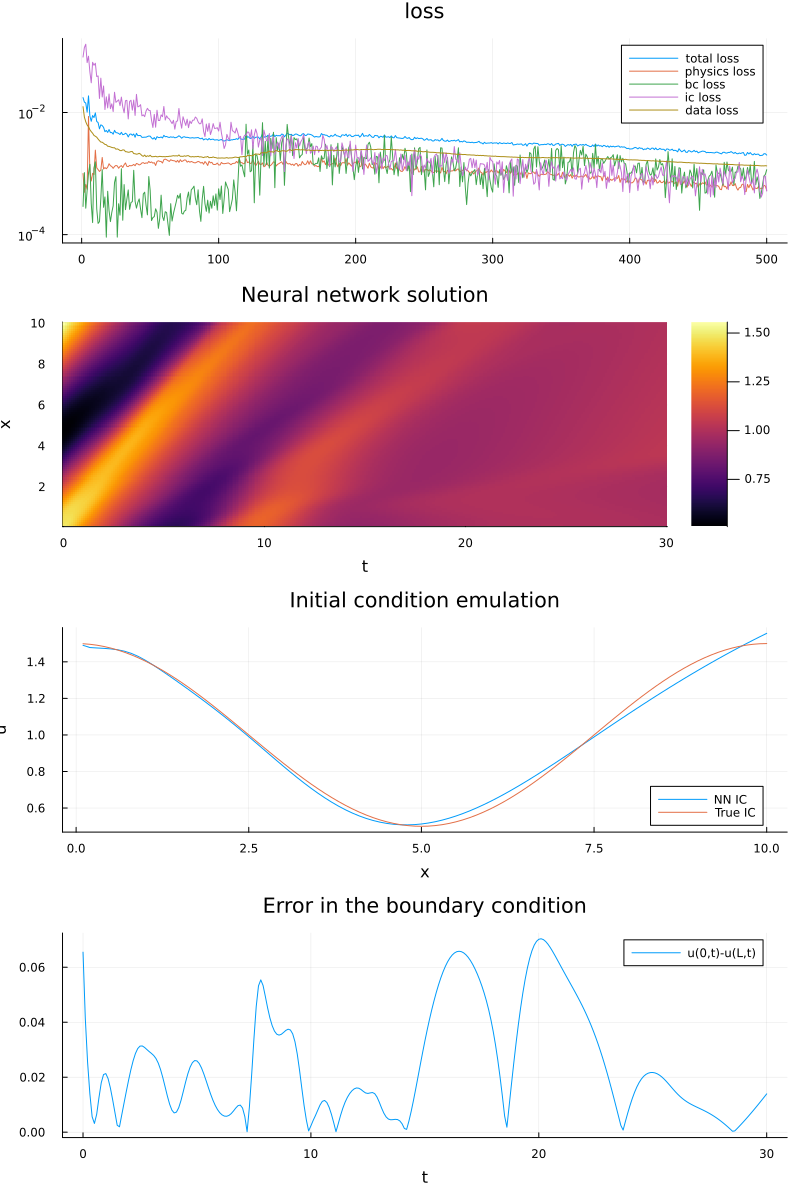

In [54]:
us = zeros(Float32, (length(x_grid), length(t_grid)))
for t_idx in 1:length(t_grid), x_idx in 1:length(x_grid)
    xt = reshape([x_grid[x_idx], t_grid[t_idx]], :, 1)
    us[x_idx, t_idx] = trained_model(xt)[1,1]
end

ic = us[:,1]
bc = abs.(us[1,:] .- us[end,:])

p0 = plot(losses.total_losses, yscale=:log10, ylabel="Loss", title="loss", label="total loss")
plot!(p0, losses.physics_losses, label="physics loss")
plot!(p0, losses.bc_losses, label="bc loss")
plot!(p0, losses.ic_losses, label="ic loss")
plot!(p0, losses.data_losses, label="data loss")
p1 = heatmap(t_grid, x_grid, us, xlabel="t", ylabel='x', title="Neural network solution")
p2 = plot(x_grid, ic, xlabel="x", ylabel="u", label="NN IC")
plot!(p2, x_grid, u0.(x_grid), label="True IC", title="Initial condition emulation")
p3 = plot(t_grid, bc, xlabel="t", ylabel="Δu", label="u(0,t)-u(L,t)", title="Error in the boundary condition")
plt = plot(p0, p1, p2, p3, layout=(4,1), size=(800,1200))
#savefig(plt, "extra_data.png");

[ Info: Saved animation to /home/mlenes/Code/surrogate_flow/emulated_burgers.gif


Plots.AnimatedGif("/home/mlenes/Code/surrogate_flow/emulated_burgers.gif")
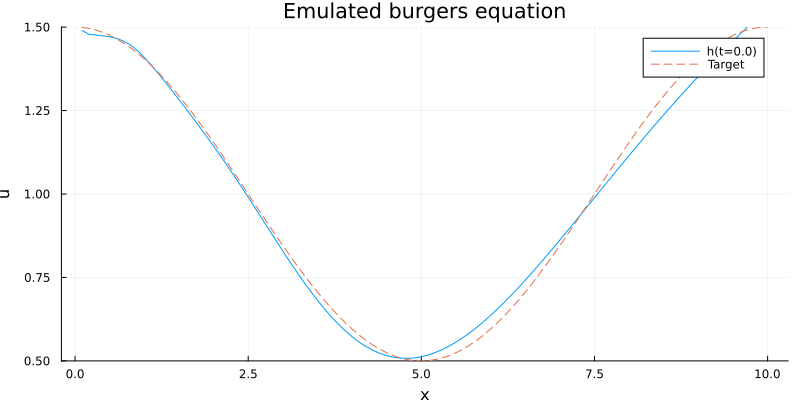

In [55]:
anim = @animate for i in 1:length(t_grid)
    p1 = plot(x_grid, us[:,i], label="h(t=$(round(t_grid[i],digits=2)))", xlabel='x', ylabel='u', ylim=(u_mean-u_amplitude, u_mean+u_amplitude))
    plot!(x_grid, u_target[i], label="Target", linestyle=:dash, legend=:topright)
    plot(p1, size=(800,400), title="Emulated burgers equation")
end
gif(anim, "emulated_burgers.gif", fps=15)